In [2]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))

In [3]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

In [4]:
def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def whistler_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return 1836 * kdi**2 / (1836 + kdi**2) * cos_theta   

def alfven_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    return kz / np.sqrt(betap)

def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

In [ ]:
theta = 0.1
betap = 1.
aol = 1e-4
the_tp = 1
tc_th = 5

t_list=[1., the_tp, the_tp * tc_th]
a_list=[1., 1., 1.]
n_list=[1.,.95,.05] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., -2, 38]
n = 10
method = 'pade'

kdi = 1

target_kde = 2
target_kdi = target_kde * np.sqrt(1836)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

In [ ]:
freqs = []
vdc_va_arr = [0, 0.3, 0.6, 1.0, 1.5, 2.0]
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

seed_freq = fast_freq(k, theta, betap)
print('seed_freq = {0:.3g}'.format(seed_freq))
for vdc_va in vdc_va_arr:
    v_list = [0, -vdc_va, n_list[1]/n_list[2]*vdc_va]
    param[8] = v_list
    freq = follow_k(seed_freq, target_k, param,
                    log_incrmt = 0.01, incrmt_method = 'log')
    freqs.append(freq)

In [ ]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq[-1]))

In [ ]:
plt.figure(figsize=[8, 6])
plt.subplot(211)
for i, vdc_va in enumerate(vdc_va_arr):
    plt.plot(kde_list, list(map(lambda x: x.real/1836,freqs[i][-1])))
plt.plot(kde_list, [whistler_freq(k*43, theta=0, betap=betap)/1836 for k in kde_list], label='analytic')
plt.xlim([2e-2, 1])
plt.ylim([1e-4, 0.4])
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\omega_r/\Omega_{ce}$')
plt.legend(loc='lower right')

plt.subplot(212)
for i, vdc_va in enumerate(vdc_va_arr):
    plt.plot(kde_list, list(map(lambda x: x.imag/1836,freqs[i][-1])), label=r'$v_{0c}/v_A=$' +'{0:.2g}'.format(vdc_va))
plt.ylim([-1e-3, 2e-3])
plt.xlim([2e-2, 1])
plt.xscale('log')
plt.legend(loc='upper right')
plt.ylabel(r'$\omega_i/\Omega_{ce}$')
plt.xlabel(r'$kc/\omega_{pe}$')
plt.tight_layout()
# plt.savefig('figure/whistler_heatflux_vs_drift.png', dpi=100)

In [ ]:
!ls figure/

## Compare with Kennel 1966

In [8]:
# v0c_va = -0
nc_nh = 19
# v0h_va = - nc_nh * nc_nh
a_c = 1
a_h = 1
thpar_tcpar = 5
tcpar_tp = 1
beta_p = 1
mi_me = 1836
thpar_tp = tcpar_tp * thpar_tcpar
# k: kdi
# omega: w / Omega_ci
def A(k, omega, v0c_va):
    v0h_va = - v0c_va * nc_nh
    v0c_vr = v0c_va / mi_me * k / (omega / mi_me - 1)
    v0h_vr = - v0c_vr * nc_nh
    vr_wparc = (omega / mi_me - 1) / k * np.sqrt(mi_me * 1/ tcpar_tp) / np.sqrt(beta_p)
    vr_wparh = (omega / mi_me - 1) / k * np.sqrt(mi_me * 1/ thpar_tp) / np.sqrt(beta_p)
    denominator_c = np.exp(- (vr_wparc * (1 - v0c_vr))**2)
    denominator_h = (1 / nc_nh / np.sqrt(thpar_tcpar)) * np.exp(-(vr_wparh * (1 - v0h_vr))**2)
    numerator_c = ((1 - v0c_vr) * a_c - 1) * denominator_c
    numerator_h = ((1 - v0h_vr) * a_h - 1) * denominator_h
    numerator = numerator_c + numerator_h
    denominator = denominator_c + denominator_h
    if numerator == 0:
        return 0
    result = numerator / denominator - 1 / (mi_me / omega - 1)
#     print('k={0:.2g}, vr_v0h={1:.2g}, vr_wparh={2:.2g}, result={3:.2g}'.format(k, 1/v0h_vr, vr_wparh, result))
    return result

In [16]:
kde_list = np.linspace(0.01, 1., 100)
kdi_list = kde_list * np.sqrt(mi_me)
# omega_list = np.array(list(map(lambda x: x.real,freqs[0][-1])))
omega_list = [whistler_freq(k, theta=0, betap=1) for k in kdi_list]

In [17]:
A_list = [A(k, omega, v0c_va=-1) for k, omega in zip(kdi_list, omega_list)]

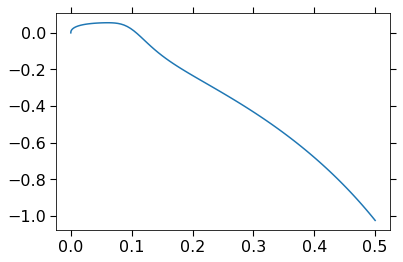

In [18]:
plt.plot(np.array(omega_list)/1836, A_list)

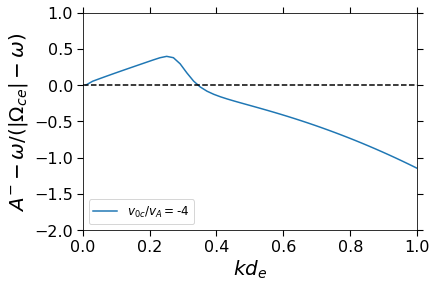

In [12]:
for v0c_va in [ -4]:
    A_list = [A(k, omega, v0c_va=v0c_va) for k, omega in zip(kdi_list, omega_list)]
    plt.plot(kdi_list / np.sqrt(mi_me), A_list, label=r'$v_{0c}/v_A=$' +'{0:.2g}'.format(v0c_va))
plt.xlabel(r'$kd_e$')
plt.ylabel(r'$A^{-} - \omega / (|\Omega_{ce}| - \omega)$')
plt.axhline(0, linestyle='dashed', color='k')
plt.xlim([0, 1])
plt.ylim([-2, 1])
plt.legend(loc='lower left', fontsize=12)
plt.show()